# SSVQE Client (Package-Only)

This notebook is a **pure client** of the `vqe` package implementation of:

**True Subspace-Search VQE (SSVQE)**:
$$
|\psi_k(\theta)\rangle = U(\theta)|\phi_k\rangle,\qquad
\min_\theta \sum_k w_k \langle \psi_k(\theta)|H|\psi_k(\theta)\rangle
$$

Key points:
- A **single shared** parameter vector `theta` for all target states.
- Orthogonality comes from the **orthogonal input determinants** $|\phi_k\rangle$.
- For UCC ansatzes, the package defaults should generate reference determinants
  from HF + (single/double) excitations, when `reference_states=None`.


In [1]:
from __future__ import annotations

from vqe.hamiltonian import build_hamiltonian
from vqe.ssvqe import run_ssvqe

In [2]:
molecule = "H2"  # "H2", "H3+", "LiH", "H2O"
num_states = 2

ansatz_name = "UCCSD"  # "UCCSD", "UCC-D", "UCC-S", "RY-CZ", "StronglyEntanglingLayers", "TwoQubit-RY-CNOT", "Minimal"
optimizer_name = "Adam"

steps = 250
stepsize = 0.2
seed = 0

# SSVQE state-ordering weights (increasing weights bias state ordering)
# If None, package defaults to [1, 2, 3, ...]
weights = [2, 1]

# Leave as None to use package defaults (HF + excitation determinants for UCC).
reference_states = None

# Noise controls
noisy = False
depolarizing_prob = 0.0
amplitude_damping_prob = 0.0


## Run SSVQE

💾 Saved SSVQE run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__SSVQE_TRUE(UCCSD)_2states__Adam__SSVQE__noiseless__s0__d8c6377d3eed.json


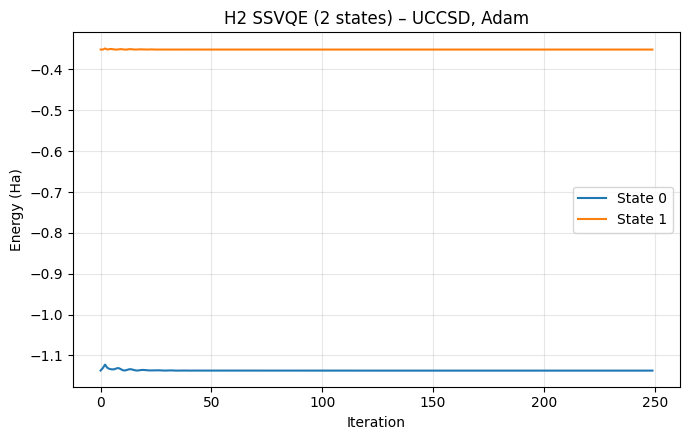

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ssvqe_conv_UCCSD_Adam.png


In [3]:
result = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    weights=weights,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=noisy,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    reference_states=reference_states,
    plot=True,
    force=True,
)

## Inspect final energies

In [4]:
energies_per_state = result["energies_per_state"]
final_energies = [traj[-1] for traj in energies_per_state]
for k, E in enumerate(final_energies):
    print(f"State {k}: final energy = {E:.10f} Ha")

State 0: final energy = -1.1372701749 Ha
State 1: final energy = -0.3511902067 Ha


In [5]:
import numpy as onp
import pennylane as qml

H, n_wires, symbols, coordinates, basis = build_hamiltonian(molecule)

H_mat = qml.matrix(H)
evals = onp.linalg.eigvalsh(onp.array(H_mat))
evals_sorted = onp.sort(evals)

print("Lowest 10 exact eigenvalues (Ha):")
for i, e in enumerate(evals_sorted[:10]):
    print(f"State {i}: {e:.10f}")


Lowest 10 exact eigenvalues (Ha):
State 0: -1.1372701749
State 1: -0.5387095807
State 2: -0.5387095807
State 3: -0.5324790143
State 4: -0.5324790143
State 5: -0.5324790143
State 6: -0.4469857253
State 7: -0.4469857253
State 8: -0.1699013991
State 9: 0.2378052722
